<a href="https://colab.research.google.com/github/Vishal64B/NNDL/blob/main/2347264_ETE3_NNDL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import zipfile
import os

# Path to uploaded ZIP file
uploaded_zip_path = '/content/Coil.zip'
extraction_path = '/content/coil-50/'

# Extract the ZIP file
with zipfile.ZipFile(uploaded_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

# Check extracted contents
extracted_files = os.listdir(extraction_path)
print(f"Extracted {len(extracted_files)} files.")

Extracted 1 files.


Dataset Loading and Preprocessing
Purpose: Loads and preprocesses the dataset for training a neural network.

  Steps:

  Resize: Images are resized to 128x128 for uniform input.

  Normalize: Pixel values are scaled to the [0, 1] range.

  Convert: Ensures all images are in RGB format.

  Directory Traversal: Uses os.walk to load .png files from all subdirectories.

  Dataset Splitting: Divides the dataset into 80% training and 20% testing using train_test_split.

  Output: Prints the total number of images, their dimensions, and the split sizes.

In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models

import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

# Set dataset path
dataset_path = extraction_path  # Directory with extracted images

# Load and preprocess images
image_size = (128, 128)  # Resize all images to 128x128
images = []
# Updated: Iterate through all subdirectories
for root, _, files in os.walk(dataset_path):
    for file_name in files:
        if file_name.endswith('.png'):  # Ensure only image files are loaded
            img_path = os.path.join(root, file_name)  # Get full image path
            # Open image and ensure it's in RGB format
            img = Image.open(img_path).convert('RGB').resize(image_size)  # Convert to RGB
            images.append(np.array(img) / 255.0)  # Normalize pixel values to [0, 1]

# Convert to NumPy array
images = np.array(images)
print(f"Loaded {images.shape[0]} images with shape {images.shape[1:]}.")

# Split into training and testing sets
train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)
print(f"Training set: {train_images.shape}, Testing set: {test_images.shape}")

Loaded 1440 images with shape (128, 128, 3).
Training set: (1152, 128, 128, 3), Testing set: (288, 128, 128, 3)


Building and Training the Autoencoder
Model Definition:

Encoder: Reduces image dimensions using convolutional layers with ReLU activation and MaxPooling.

Decoder: Reconstructs images using transpose convolutional layers and UpSampling.

Final output uses a sigmoid activation for normalized pixel values.
Input Shape:

The model expects images of size 128x128x3 (RGB format).
Compilation:

Optimizer: Adam with a learning rate of 0.001.
Loss: Mean Squared Error (MSE).
Training:

Trains for 20 epochs with a batch size of 32.
Validation is performed on the test set to monitor reconstruction performance.


In [15]:
# Define the autoencoder
def build_autoencoder(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    encoded = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)

    # Decoder
    x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(encoded)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = models.Model(inputs, decoded)
    return autoencoder

# Input shape
input_shape = (128, 128, 3)

# Build and compile the model
autoencoder = build_autoencoder(input_shape)
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')
autoencoder.summary()

# Train the autoencoder
history = autoencoder.fit(
    train_images, train_images,
    validation_data=(test_images, test_images),
    epochs=20,
    batch_size=32,
    shuffle=True
)


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_10                  │ (None, 32, 32, 64)          │          73,792 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_10 (UpSampling2D)      │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_11                  │ (None, 64, 64, 32)          │          18,464 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_11 (UpSampling2D)      │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 128, 128, 3)         │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 186,371 (728.01 KB)

 Trainable params: 186,371 (728.01 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - loss: 0.0815 - val_loss: 0.0106
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.0078 - val_loss: 0.0054
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0049 - val_loss: 0.0038
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0038 - val_loss: 0.0034
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0034 - val_loss: 0.0028
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0026 - val_loss: 0.0024
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 9/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 10/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 11/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 12/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0

Architecture of the CNN Autoencoder:

The build_autoencoder function defines the architecture of the model, and autoencoder.summary() displays the layer details.

## 4.Model Evaluation
####Test MSE Calculation: The model is evaluated on the test set, and the final Mean Squared Error (MSE) is printed to assess the reconstruction quality.

In [16]:
# Evaluate the model on the test set
test_loss = autoencoder.evaluate(test_images, test_images)
print(f"Final Test MSE: {test_loss}")


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0013
Final Test MSE: 0.0013116190675646067


## 3. Original vs. Reconstructed

Reconstruction Visualization:

The first 5 images from the test set are reconstructed by the autoencoder. Both the original and reconstructed images are displayed side by side for comparison.

The original images are shown on the top row.
The reconstructed images are shown on the bottom row.
The pixel values are clipped to ensure valid range [0, 1] for visualization.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 771ms/step


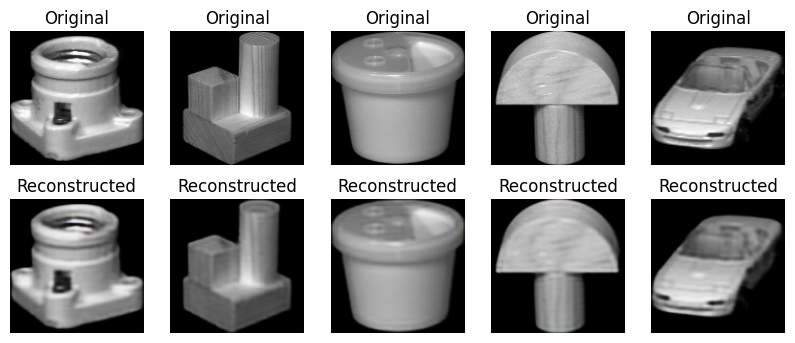

In [17]:
# Reconstruct some test images
decoded_images = autoencoder.predict(test_images[:5])

# Plot original vs reconstructed images
plt.figure(figsize=(10, 4))
for i in range(5):
    # Original images
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(test_images[i])
    plt.title("Original")
    plt.axis("off")

    # Reconstructed images
    ax = plt.subplot(2, 5, i + 6)
    plt.imshow(np.clip(decoded_images[i], 0, 1))  # Ensure valid pixel values
    plt.title("Reconstructed")
    plt.axis("off")
plt.show()


#2. Loss Curve During Training
Training and Validation Loss Visualization:

This plot shows the training and validation loss (MSE) over 20 epochs.

The Training Loss is shown with a line representing the model's performance on the training set.

The Validation Loss is shown to track how well the model generalizes to the test set.

This helps in monitoring if the model is overfitting or underfitting.

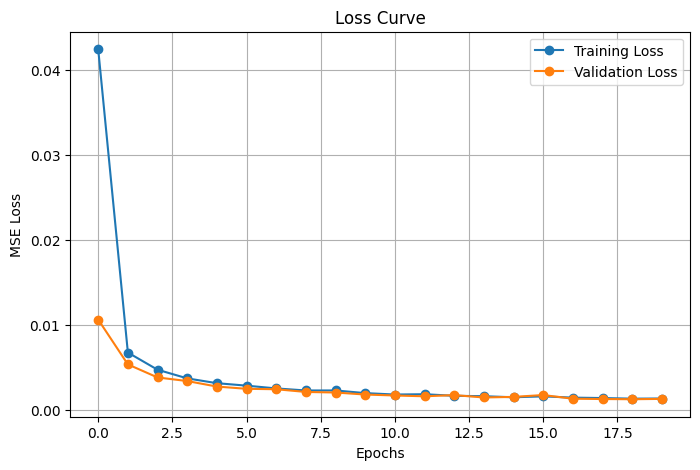

In [18]:
# Plot training and validation loss curves
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.grid(True)
plt.legend()
plt.show()
